# Simple Synthetic Inversions

## Import packages

In [179]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import RIS_gravity_inversion.plotting as inv_plotting

import logging

import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import inversion, plotting, synthetic, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

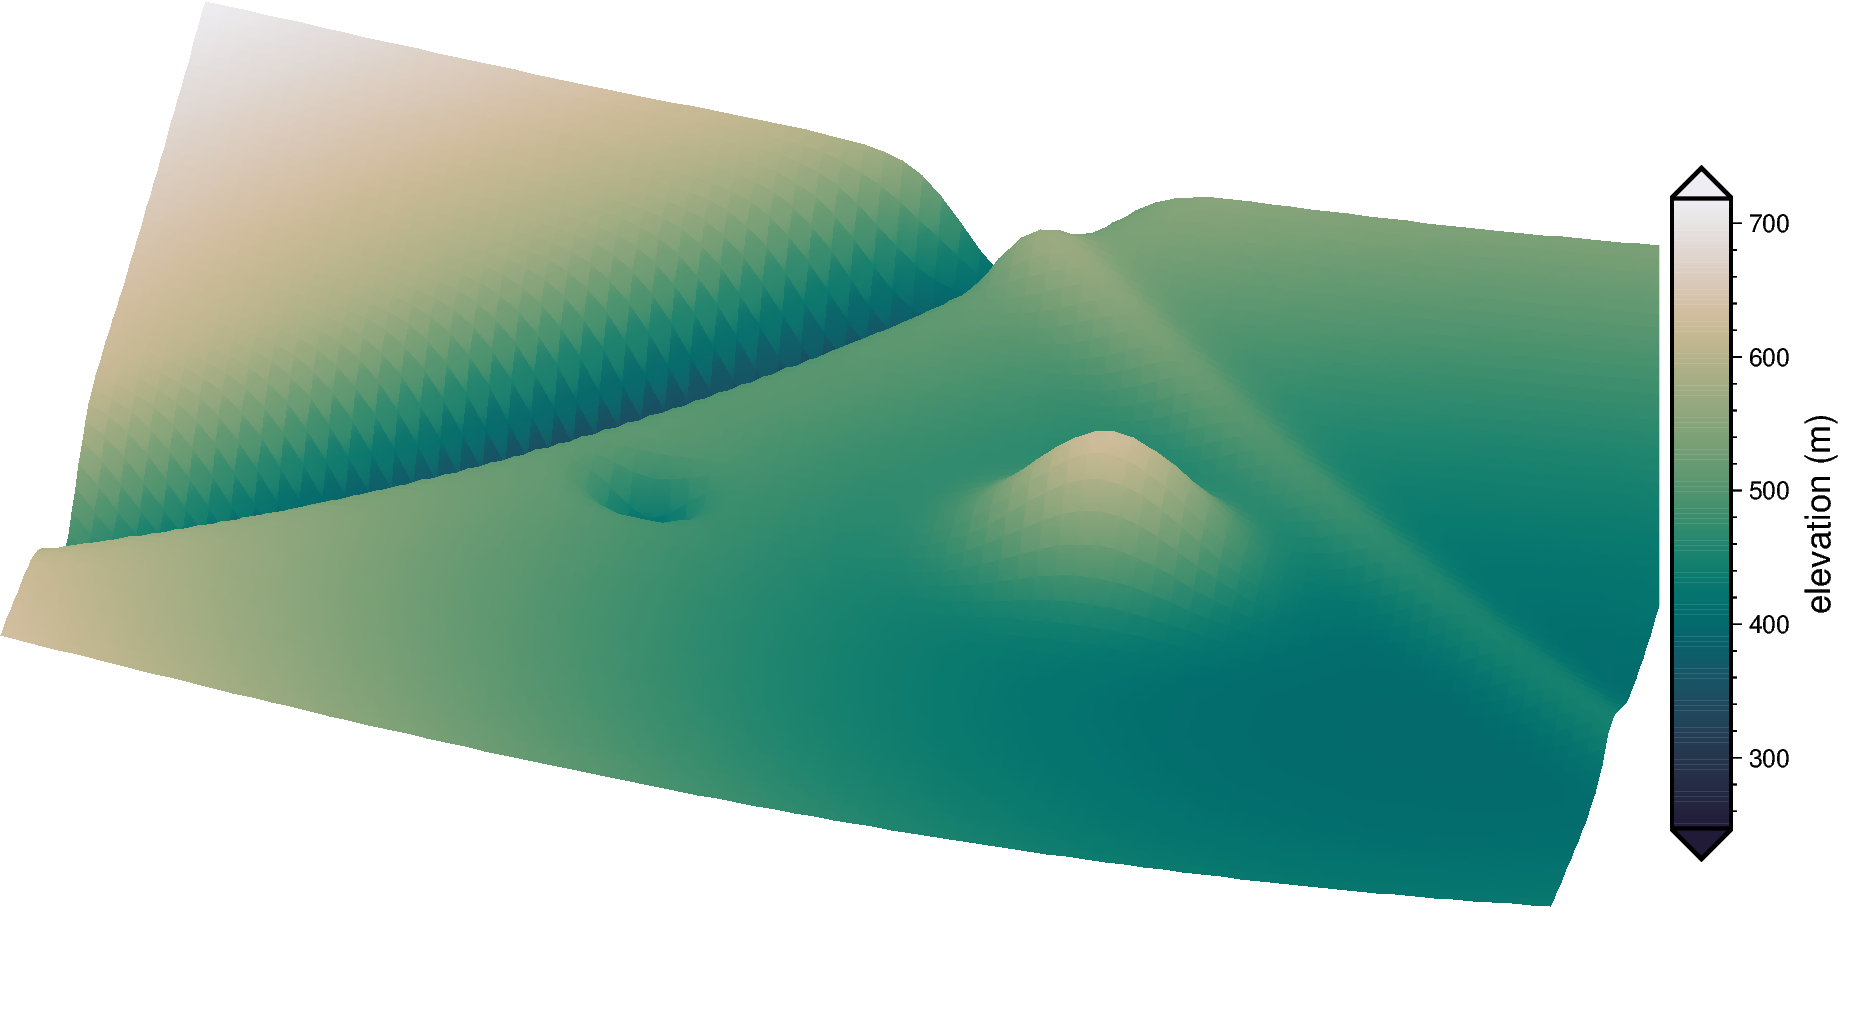

<xarray.DataArray 'upward' (northing: 61, easting: 81)> Size: 40kB
array([[637.12943453, 632.19538446, 627.28784729, ..., 429.33158321,
        429.94283295, 430.64751872],
       [634.98693024, 630.03468543, 625.10864111, ..., 426.39921792,
        427.01279345, 427.72016051],
       [632.95724141, 627.98926162, 623.04617819, ..., 423.6241977 ,
        424.23997422, 424.94987872],
       ...,
       [709.90739328, 705.61112993, 701.33808009, ..., 528.97704204,
        529.50925875, 530.12283044],
       [714.19597392, 709.93730524, 705.70164695, ..., 534.84886306,
        535.37642258, 535.98462518],
       [718.55151946, 714.33103249, 710.13334959, ..., 540.8123708 ,
        541.33520041, 541.93795008]])
Coordinates:
  * easting   (easting) float64 648B 0.0 500.0 1e+03 ... 3.9e+04 3.95e+04 4e+04
  * northing  (northing) float64 488B 0.0 500.0 1e+03 ... 2.9e+04 2.95e+04 3e+04

In [154]:
# set grid parameters
spacing = 500
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

# plot the true topography
fig = maps.plot_3d(
    true_topography,
    fig_height=10,
    exaggeration=3,
    title="True topography",
    cmaps="rain",
    reverse_cpt=True,
    grd2_cpt=True,
    cbar_labels="elevation (m)",
    cbar_perspective=False,
    frame=["nSWe", "xaf10000", "yaf10000"],
    # zshifts=[10],
    # cbar_yshift=[0, 4],
)

fig.show()

true_topography

### Prism layer

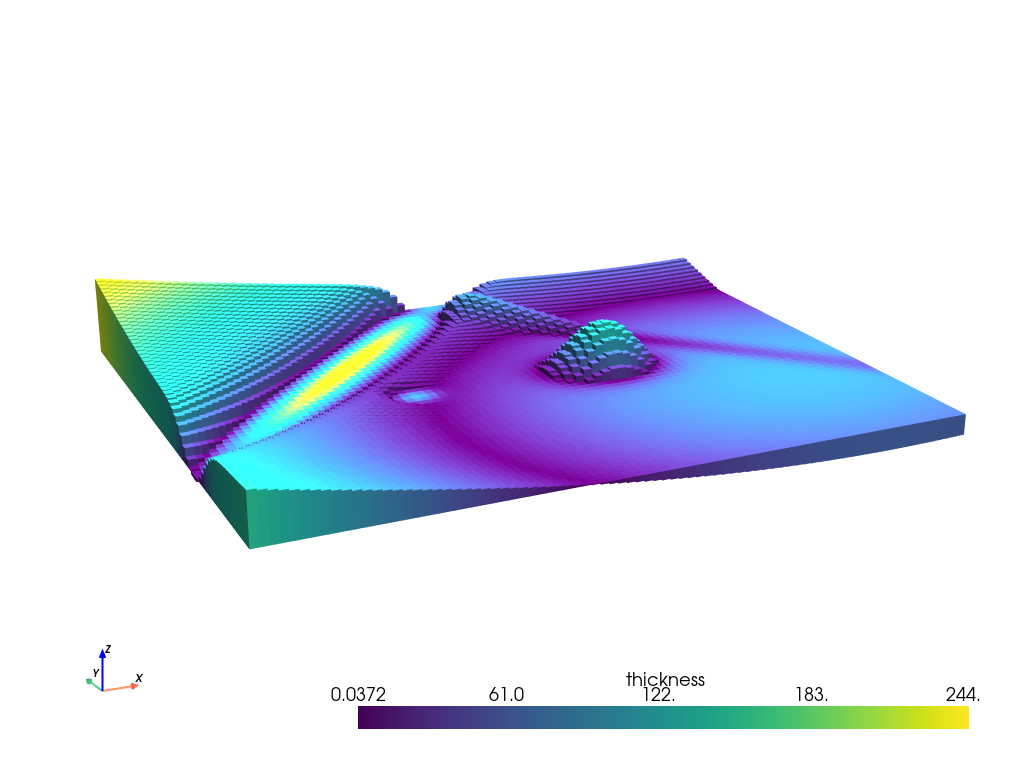

mean topography is 490.93632804524606 m


In [155]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

print(f"mean topography is {zref} m")

### Forward gravity of prism layer

In [156]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,6.973239
1,0.0,500.0,1000.0,8.543041
2,0.0,1000.0,1000.0,8.808350
3,0.0,1500.0,1000.0,8.728426
4,0.0,2000.0,1000.0,8.524345
...,...,...,...,...
4936,30000.0,38000.0,1000.0,2.835035
4937,30000.0,38500.0,1000.0,2.818610
4938,30000.0,39000.0,1000.0,2.767819
4939,30000.0,39500.0,1000.0,2.610552


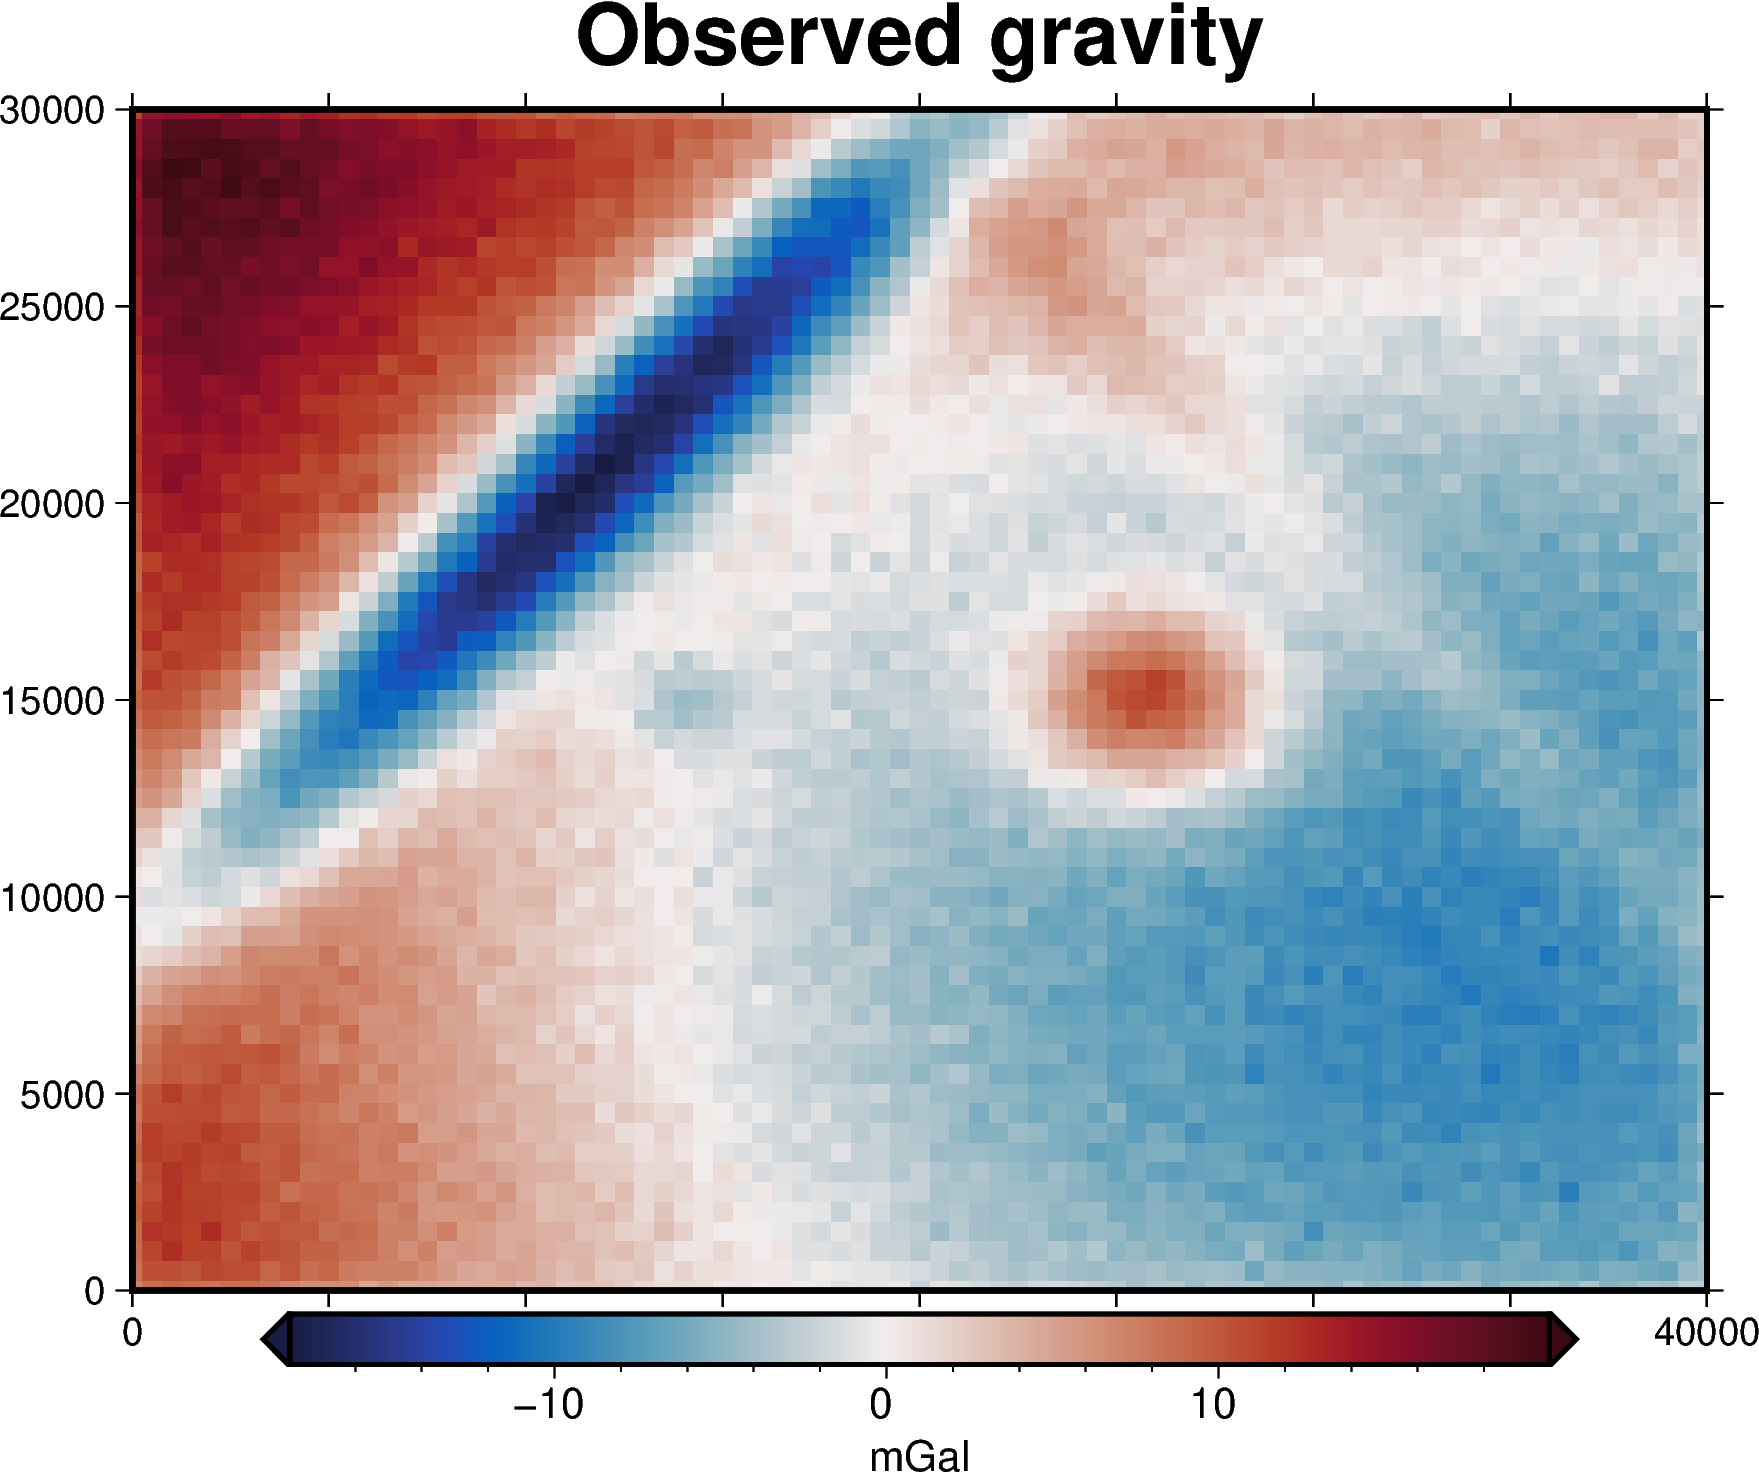

In [157]:
# contaminate gravity with 0.5 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

# plot the observed gravity
fig = maps.plot_grd(
    grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav,
    fig_height=10,
    title="Observed gravity",
    cmap="balance+h0",
    grd2_cpt=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

## Gravity misfit
Now we need to create a starting model of the topography to start the inversion with. We will simulate known the topography at 10 points.

In this simple case, we assume that we know the true density contrast and appropriate reference value for the topography (`zref`), and use these values to create our flat starting model. Note that in a real world scenario, these would be unknowns which would need to be carefully chosen, as explained in the following notebooks.

In [165]:
# create 10 random point within the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# grid the sampled values using verde
grd = vd.Spline()
coords = (constraint_points.easting, constraint_points.northing)
grd.fit(coords, constraint_points.upward)
starting_topography = grd.grid(
    region=region,
    spacing=spacing,
).scalars

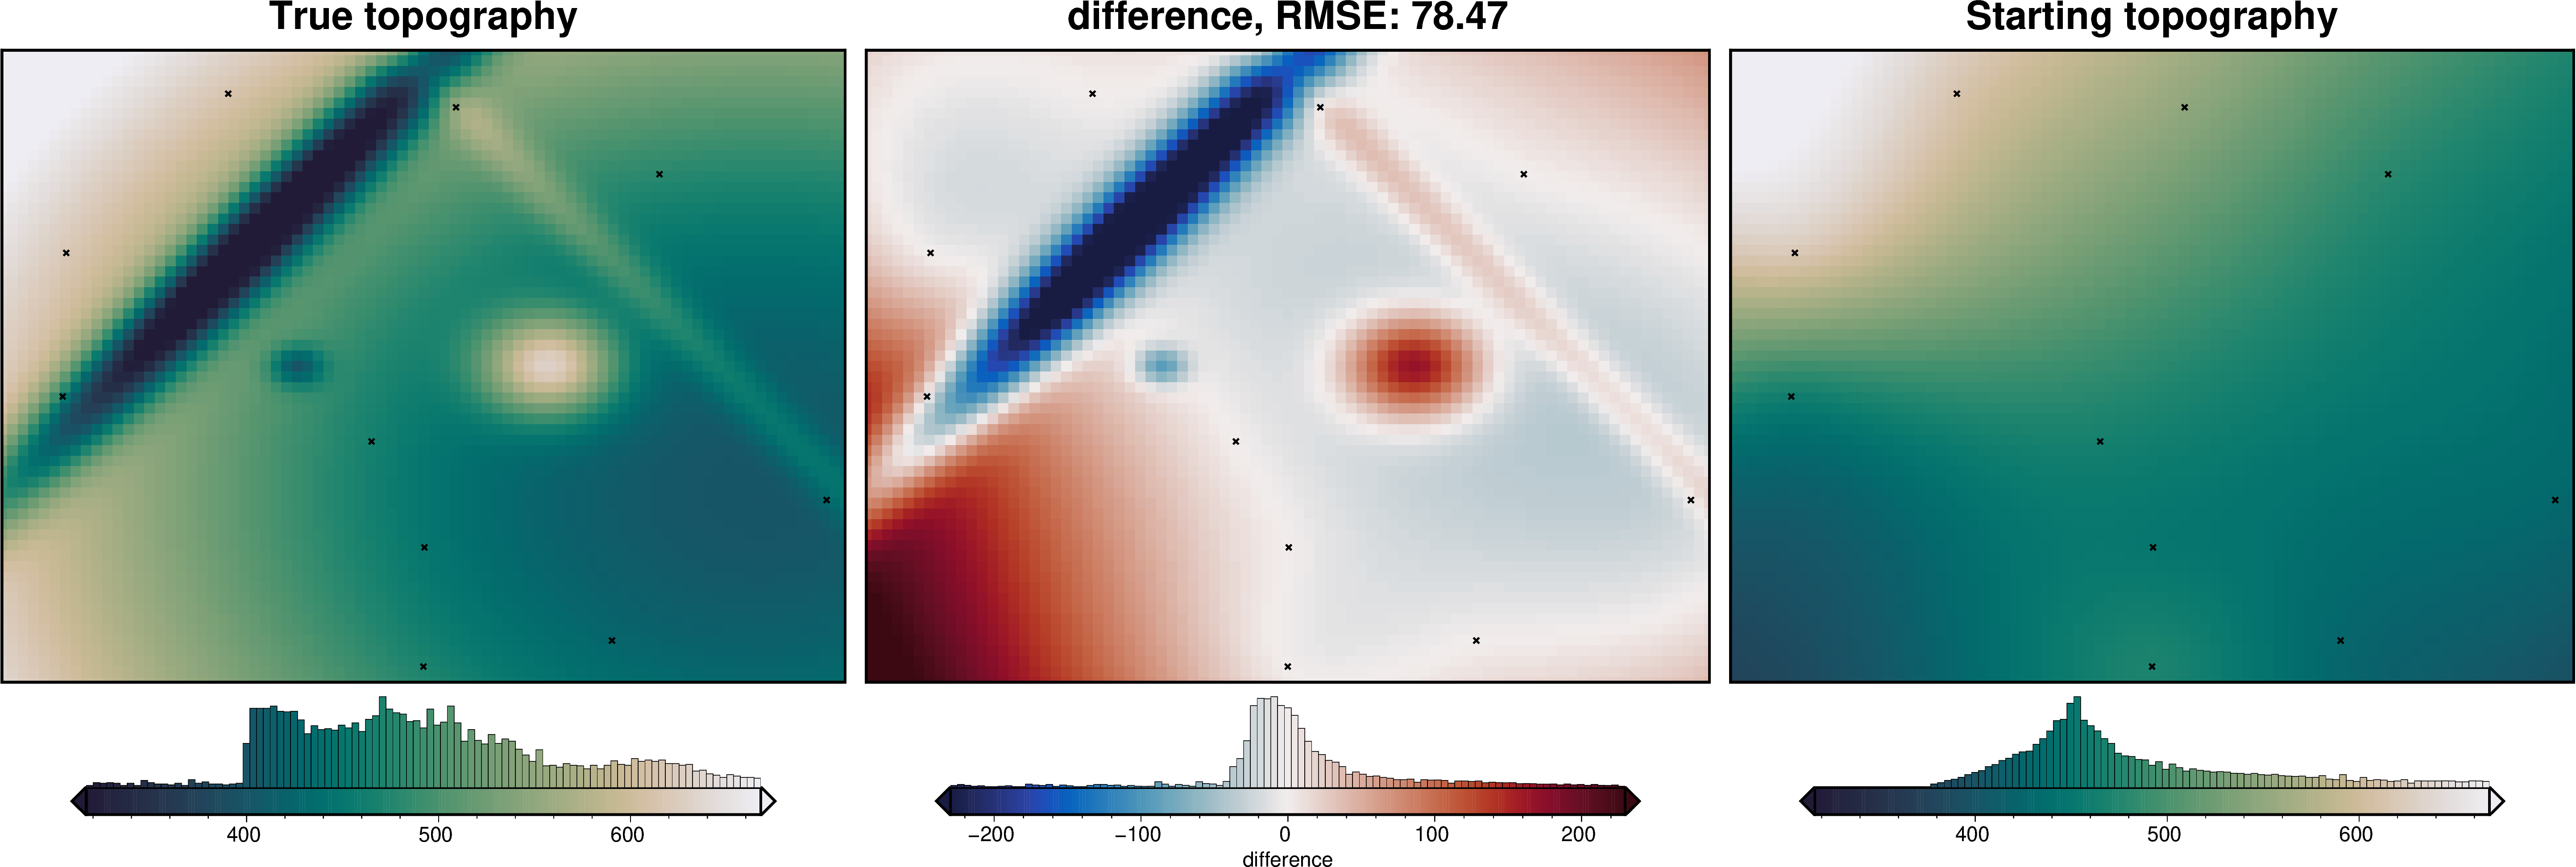

In [167]:
_ = polar_utils.grd_compare(
    true_topography,
    starting_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

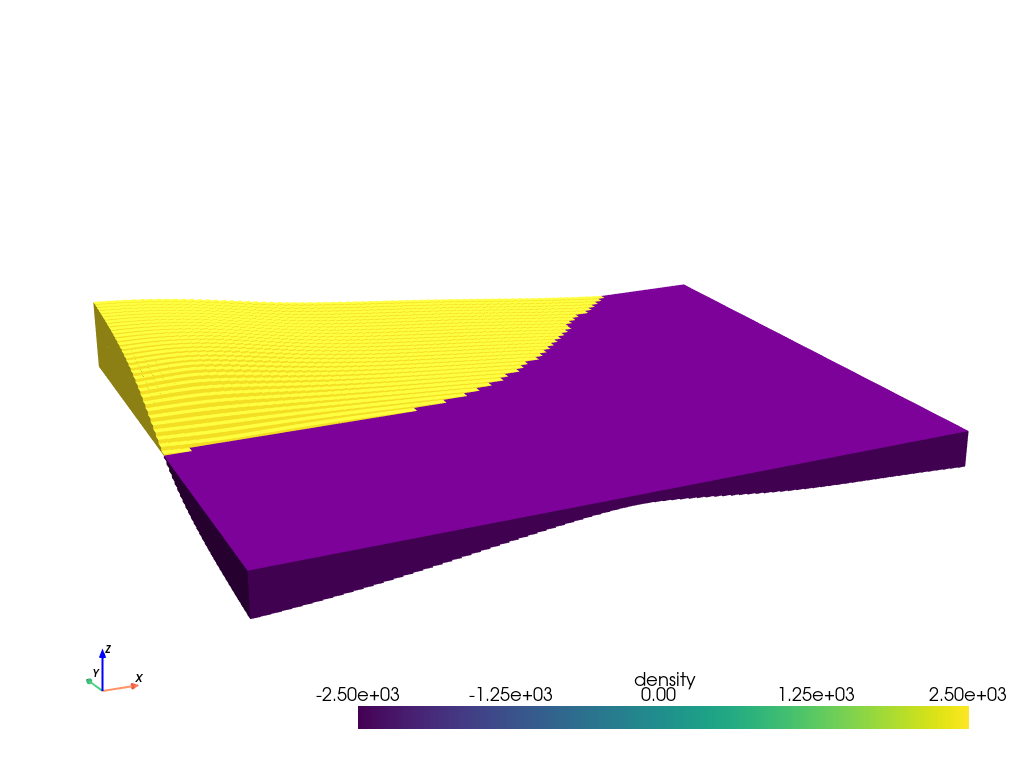

In [171]:
zref = np.mean(constraint_points.upward)

# the true density contrast is 2669, between rock (~2670 kg/m3) and air (~1 kg/m3)
# We will guess an approximate density contrast, of 2500
density_contrast = 2500

density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [172]:
# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,grav,observed_grav,misfit,reg,res,starting_grav
0,0.0,0.0,1000.0,6.973239,7.039041,11.953136,0,11.953136,-4.914095
1,0.0,500.0,1000.0,8.543041,8.479926,14.689999,0,14.689999,-6.210073
2,0.0,1000.0,1000.0,8.808350,9.131498,15.803842,0,15.803842,-6.672344
3,0.0,1500.0,1000.0,8.728426,8.783813,15.626987,0,15.626987,-6.843175
4,0.0,2000.0,1000.0,8.524345,8.259447,15.153434,0,15.153434,-6.893987
...,...,...,...,...,...,...,...,...,...
4936,30000.0,38000.0,1000.0,2.835035,3.715287,4.872466,0,4.872466,-1.157179
4937,30000.0,38500.0,1000.0,2.818610,2.330026,3.566333,0,3.566333,-1.236308
4938,30000.0,39000.0,1000.0,2.767819,3.488902,4.776800,0,4.776800,-1.287898
4939,30000.0,39500.0,1000.0,2.610552,1.850431,3.122710,0,3.122710,-1.272279


## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

INFO:root:starting inversion
INFO:root:extracted prism spacing is 500.0


Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:root:
 #################################### 
 iteration 1
INFO:root:Layer correction median: -3.8692 m, RMSE:33.3206 m
INFO:root:updated misfit RMSE: 4.0247
INFO:root:updated L2-norm: 2.0062, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.3074, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: 0.4669 m, RMSE:19.2231 m
INFO:root:updated misfit RMSE: 2.4355
INFO:root:updated L2-norm: 1.5606, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2855, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 2.0125 m, RMSE:11.3458 m
INFO:root:updated misfit RMSE: 1.5516
INFO:root:updated L2-norm: 1.2456, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2529, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: 1.5689 m, RMSE:6.8983 m
INFO:root:updated misfit RMSE: 1.0632
INFO:root:updated L2-norm: 1.

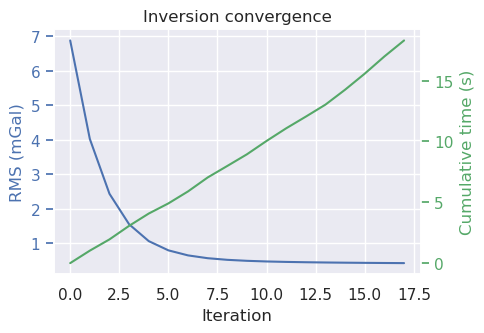

In [173]:
# set Python's logging level to get information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    input_grav_column="observed_grav",
    prism_layer=starting_prisms,
    zref=zref,
    density_contrast=density_contrast,
    # display the convergence of the inversion
    plot_convergence=True,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    deriv_type="annulus",
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.005,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

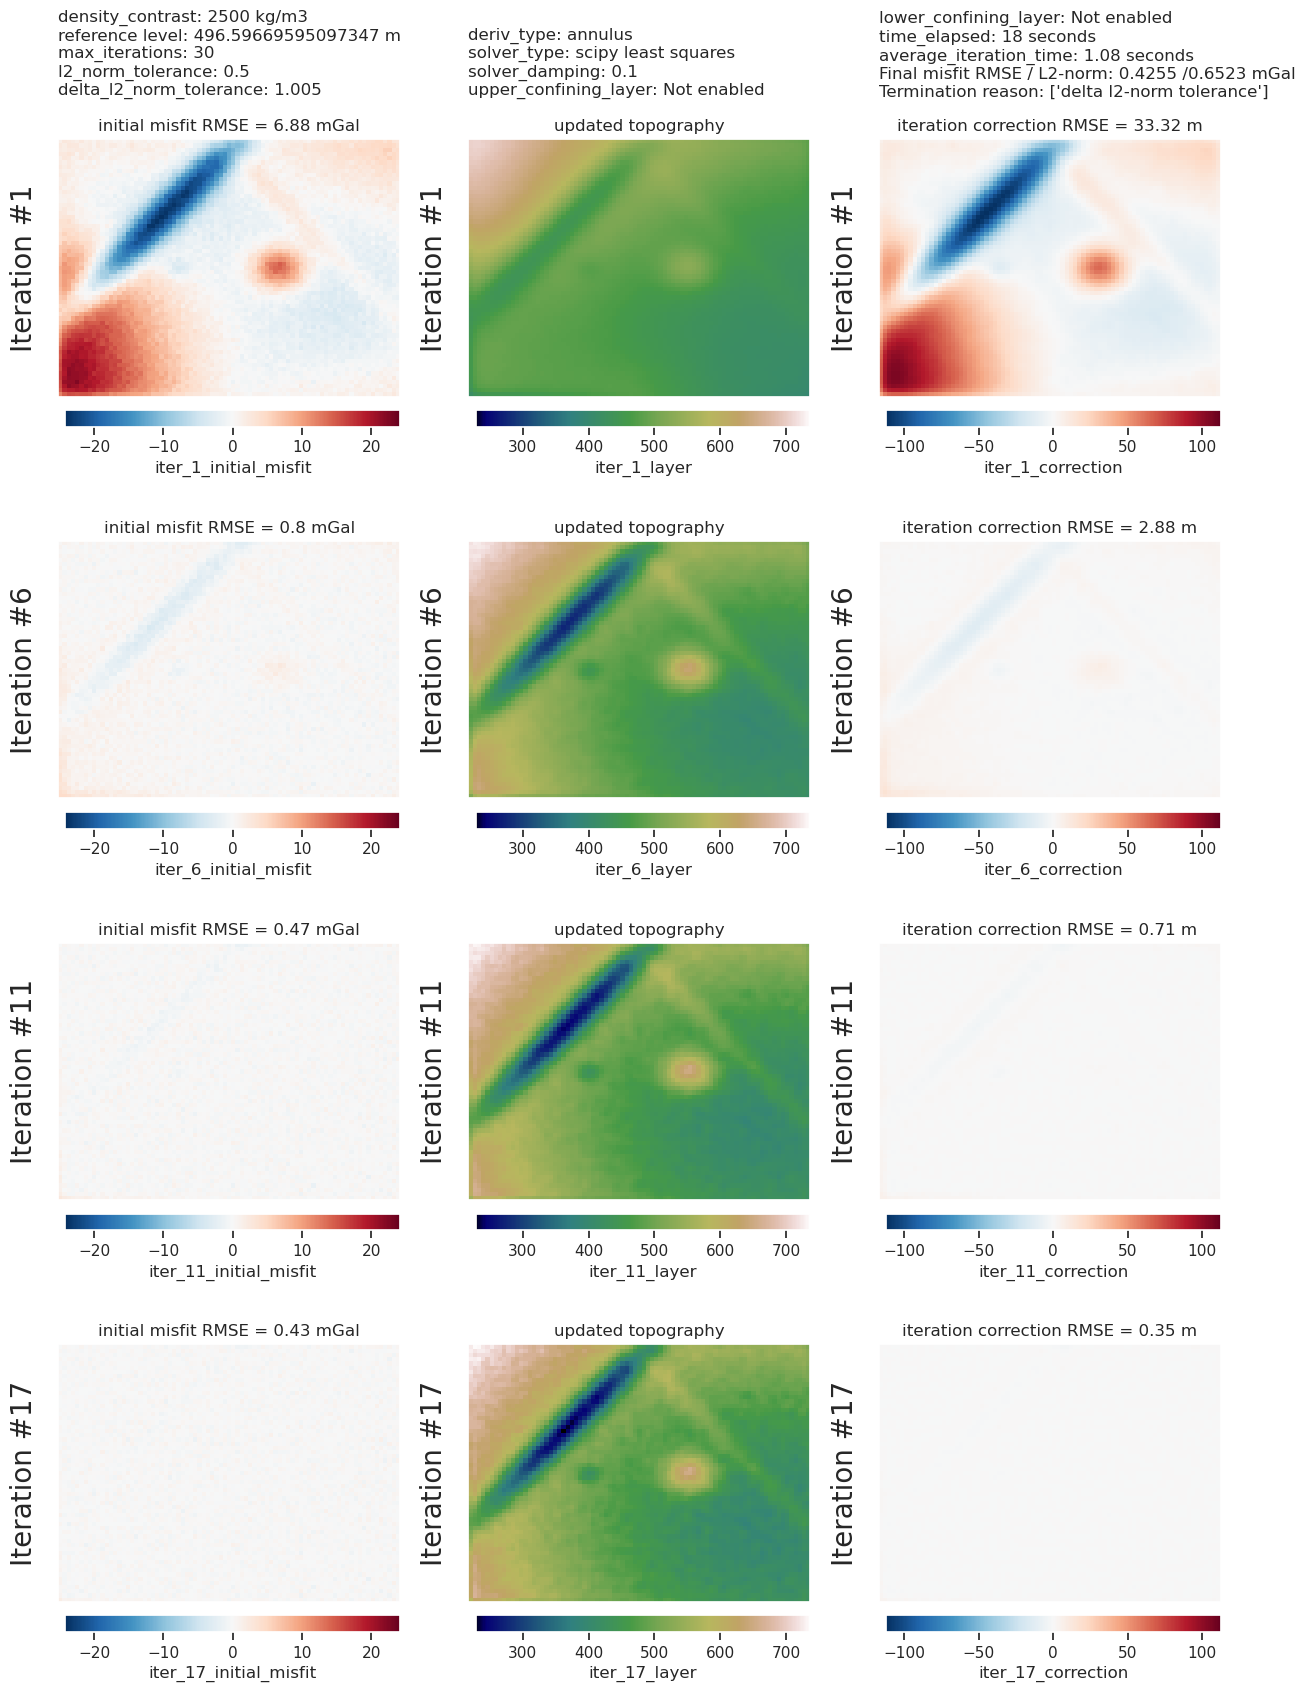

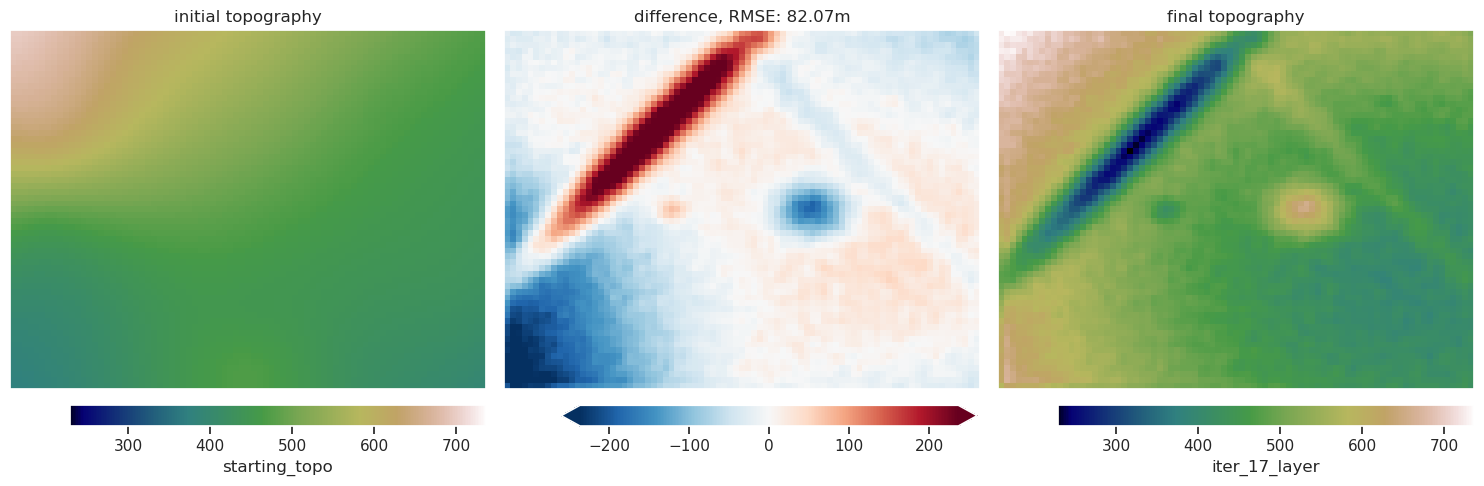

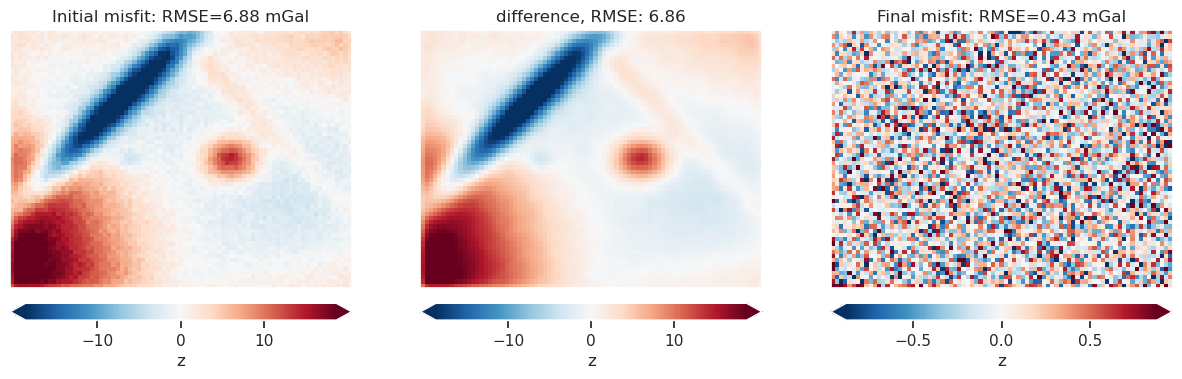

In [174]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

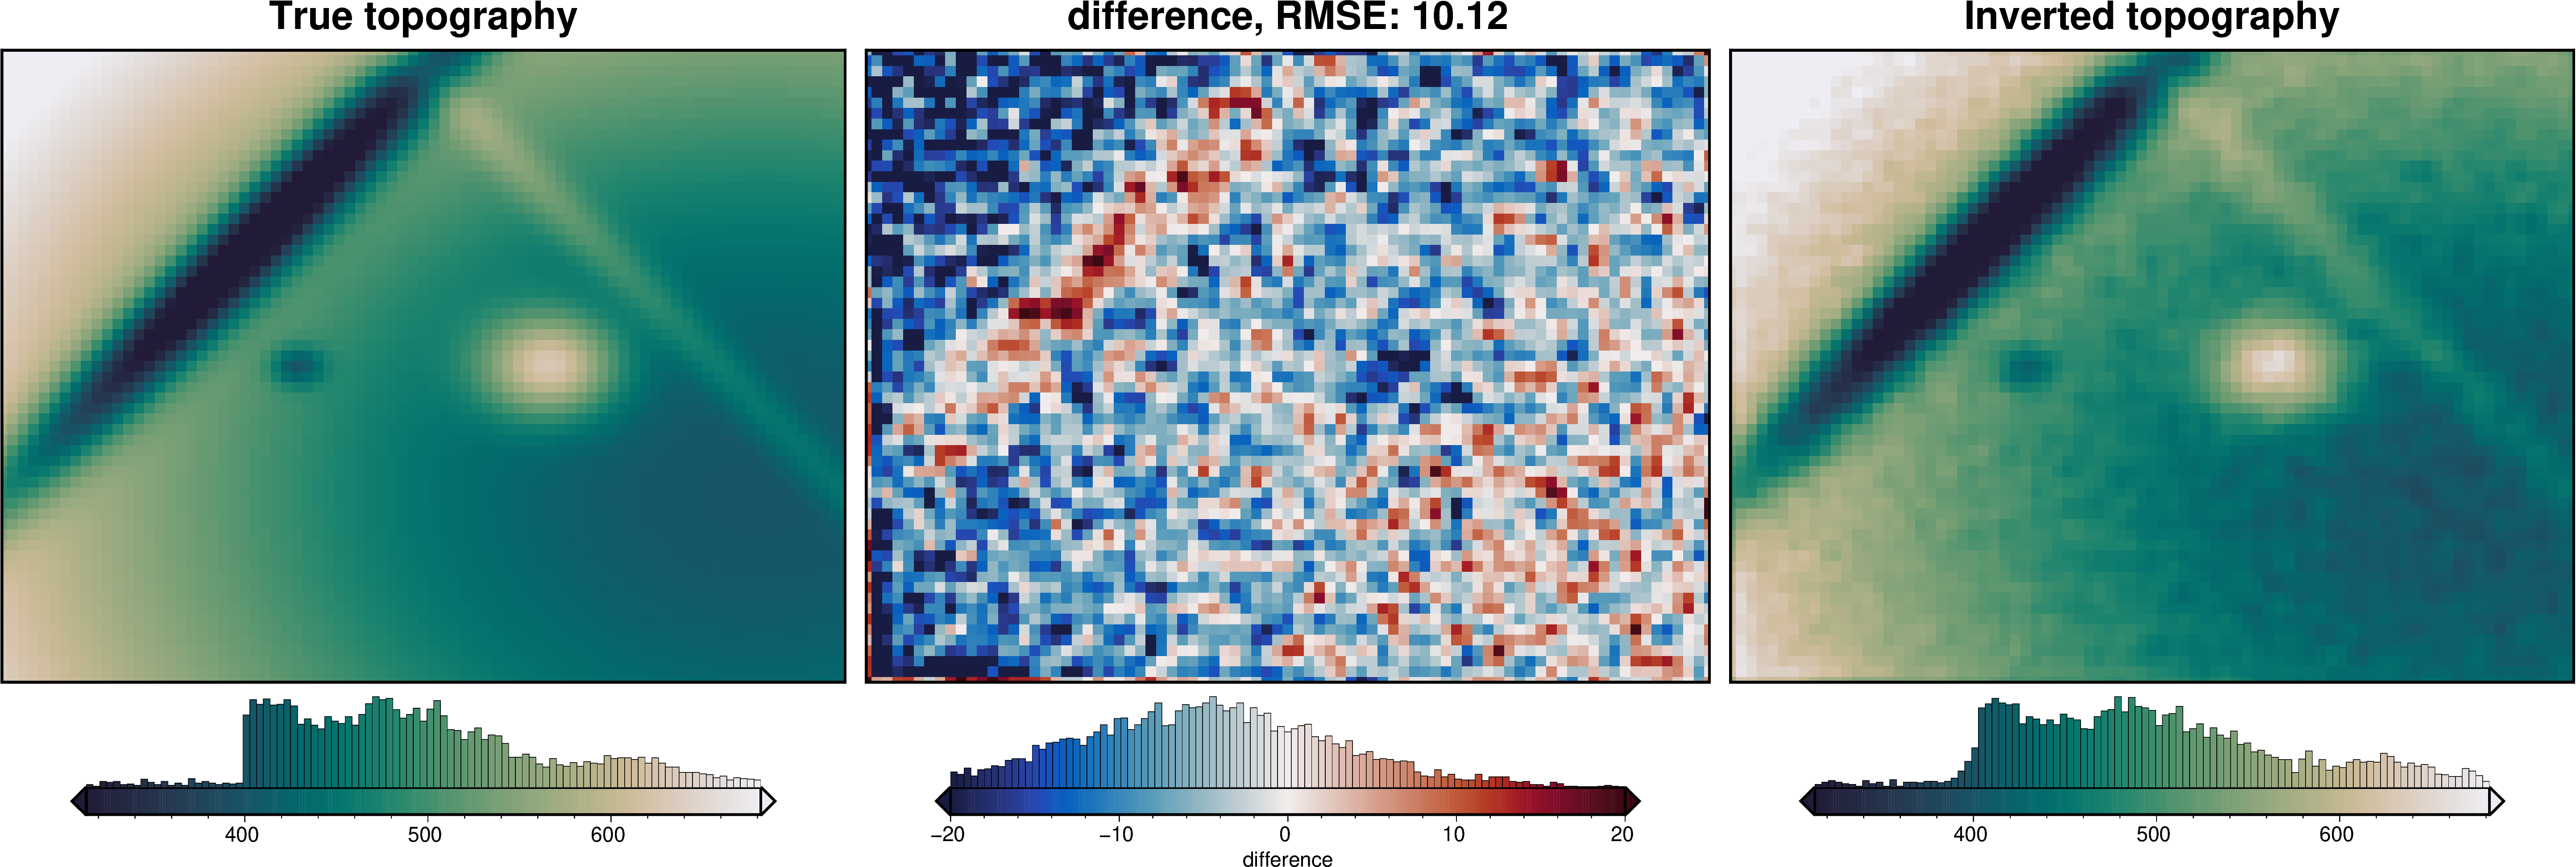

In [182]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    diff_lims=(-20, 20),
)

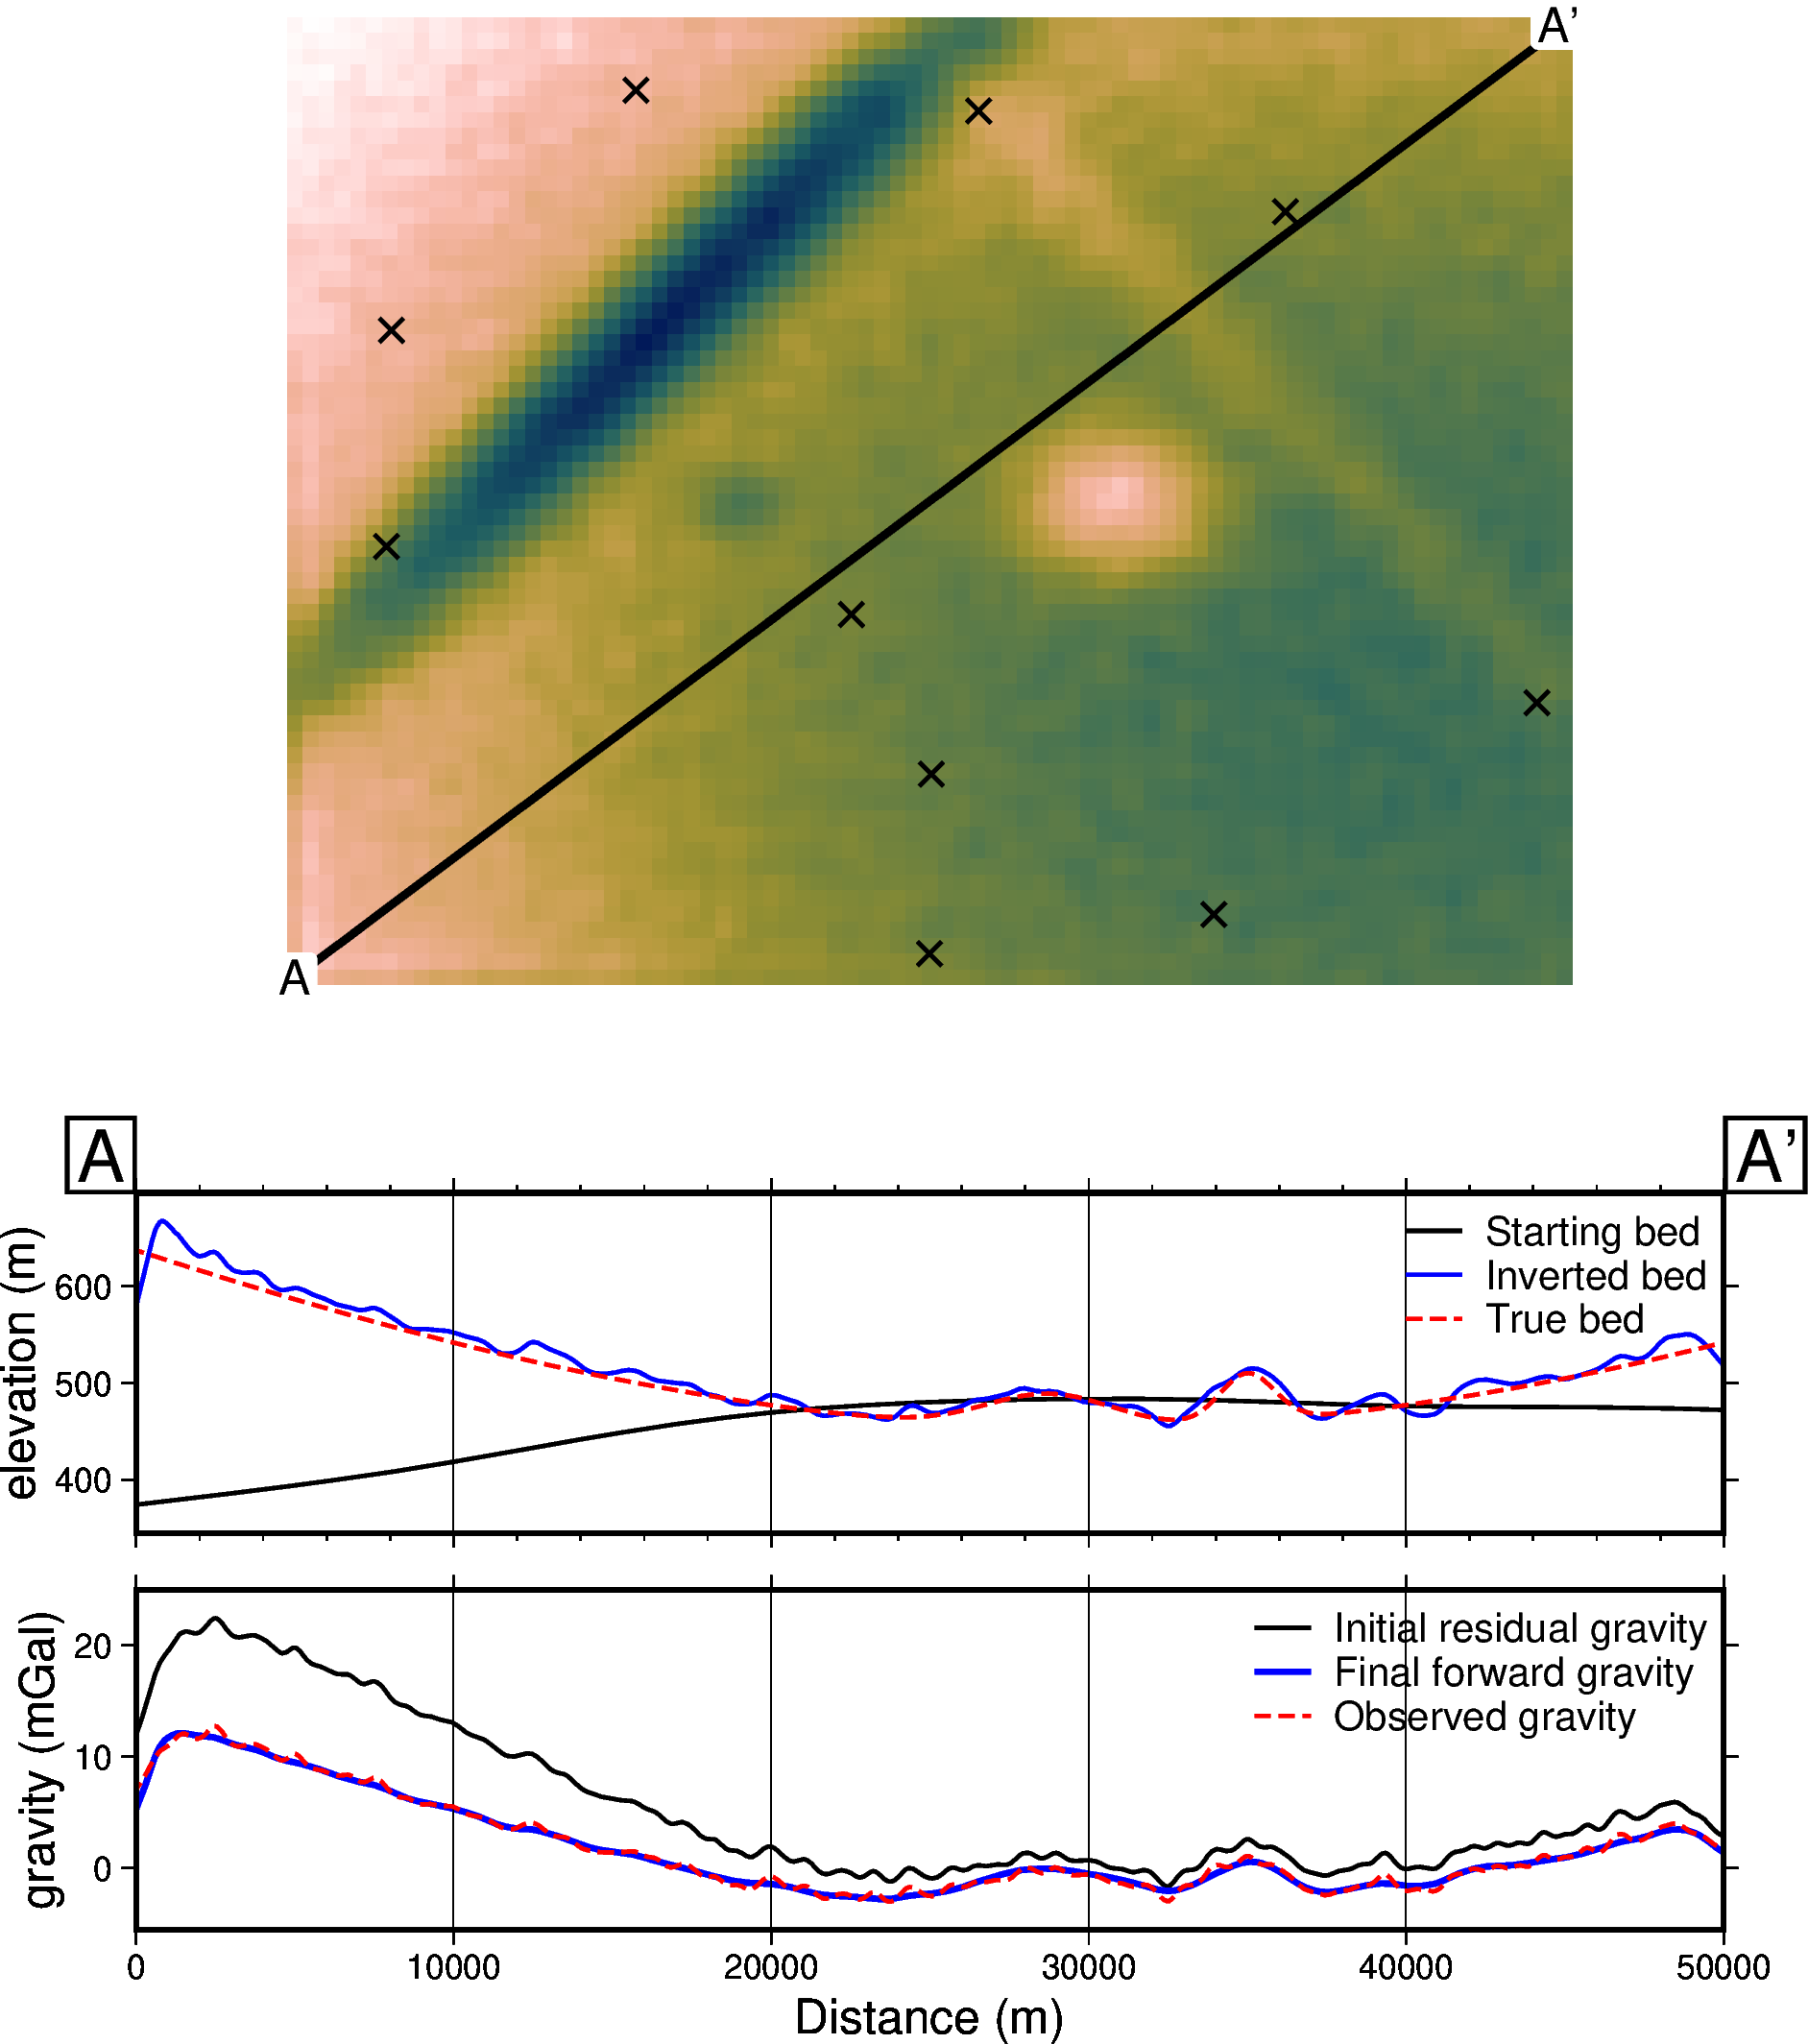

In [ ]:
fig = inv_plotting.plot_inversion_results_profile(
    topo_results,
    grav_results,
    observed_grav_column="observed_grav",
    constraints=constraint_points,
    true_surface=true_topography,
    start=[region[0], region[2]],
    stop=[region[1], region[3]],
    map_buffer=0.1,
    subplot_orientation="vertical",
    data_legend_loc="jTR+o0c",
    layers_legend_loc="jTR+o0c",
)
fig.show()